In [1]:
import cartopy.crs as ccrs
import matplotlib.dates as mdates
import matplotlib.units as munits
import numpy as np
import pandas as pd
import xarray as xr
import wandb

import plotting
import utils

converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter

In [2]:
TITLE_TEMPLATE = """{name}
Global {metric_name} = {g:0.2f}
Land {metric_name} = {l:0.2f}
Ocean/sea-ice {metric_name} = {n:0.2f}"""

NO_NAME_TITLE_TEMPLATE = """Global {metric_name} = {g:0.2f}
Land {metric_name} = {l:0.2f}
Ocean/sea-ice {metric_name} = {n:0.2f}"""

In [3]:
plotting.configure_style()

In [4]:
TIME_SERIES_MODELS = ["SHiELD-SOM-C96", "ACE2-SOM-multi-climate-RS3"]
ONE_DEGREE_MODELS = ["SHiELD-SOM-C96", "ACE2-SOM-multi-climate-RS3"]
FOUR_DEGREE_MODELS = [
    "SHiELD-SOM-C96",
    "ACE2-SOM-multi-climate-RS3",
    "SHiELD-SOM-C24-tuned-cdmbgwd",
]
CLIMATES = ["3xCO2"]
VARIABLES = ["surface_temperature", "PRATEsfc"]

catalog = pd.read_csv("../scripts/inference-run-catalog.csv")

In [5]:
def load_global_daily_mean_metrics(wandb_run, variables):
    pattern = "inference/mean/weighted_mean_gen/{variable}"
    keys = [pattern.format(variable=variable) for variable in variables]
    metrics = pd.DataFrame(wandb_run.scan_history(keys=keys))

    metrics["time"] = pd.date_range(
        "2031-01-01T06", periods=len(metrics.index), freq="6h"
    )
    metrics = metrics.set_index("time")

    ds = xr.Dataset.from_dataframe(metrics)
    ds = ds.resample(time="D").mean().sel(time=slice("2031", "2040"))

    ds = ds.rename({pattern.format(variable=v): v for v in variables})
    return ds


def load_time_series_data(catalog, models, climates, variables):
    api = wandb.Api()
    cases = catalog[catalog["model"].isin(models) & catalog["forcing"].isin(climates)]
    datasets = {}
    for _, case in cases.iterrows():
        wandb_run = api.run(case["wandb_id"])
        ds = load_global_daily_mean_metrics(wandb_run, variables)
        key = case["model"], case["forcing"], case["initial_condition"]
        datasets[key] = ds

    index = pd.MultiIndex.from_tuples(
        datasets.keys(), names=("model", "climate", "initial_condition")
    )
    combined = utils.safe_concat(datasets.values(), dim="case")
    result = combined.assign_coords(case=index).unstack("case")
    return utils.scale_precipitation(result)

In [6]:
time_series = load_time_series_data(catalog, TIME_SERIES_MODELS, CLIMATES, VARIABLES)

/tmp/ipykernel_2974/1288638455.py:32: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'case' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  result = combined.assign_coords(case=index).unstack("case")


In [7]:
regridder = utils.get_regridder()
one_degree = utils.load_time_mean_data(
    catalog, ONE_DEGREE_MODELS, CLIMATES, VARIABLES
).mean("initial_condition")
four_degree = utils.load_time_mean_data(
    catalog,
    FOUR_DEGREE_MODELS,
    CLIMATES,
    VARIABLES,
    target_resolution=4,
    regridder=regridder,
).mean("initial_condition")

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

/home/spencerc/ace2-som-paper/notebooks/utils.py:175: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'case' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  result = combined.assign_coords(case=index).unstack("case")


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

/home/spencerc/ace2-som-paper/notebooks/utils.py:175: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'case' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  result = combined.assign_coords(case=index).unstack("case")


In [8]:
def compute_bias(ds, dim, reference_case):
    return ds.drop_sel({dim: reference_case}) - ds.sel({dim: reference_case})

In [9]:
one_degree_weights = utils.get_weights("gaussian_grid_180_by_360")
four_degree_weights = utils.get_weights("gaussian_grid_45_by_90")

one_degree_pattern_error = one_degree.drop_sel(model="SHiELD-SOM-C96") - one_degree.sel(
    model="SHiELD-SOM-C96"
)
four_degree_pattern_error = four_degree.drop_sel(
    model="SHiELD-SOM-C96"
) - four_degree.sel(model="SHiELD-SOM-C96")

rmse = np.sqrt(
    (four_degree_pattern_error**2).weighted(four_degree_weights).mean(["lon", "lat"])
)

In [10]:
def get_title(metric, variable, climate, model, metric_name):
    sel_kwargs = {"model": model, "climate": climate}
    g = metric.sel(region="global", **sel_kwargs)[variable].item()
    l = metric.sel(region="land", **sel_kwargs)[variable].item()
    n = metric.sel(region="non-land", **sel_kwargs)[variable].item()
    return NO_NAME_TITLE_TEMPLATE.format(metric_name=metric_name, g=g, l=l, n=n)

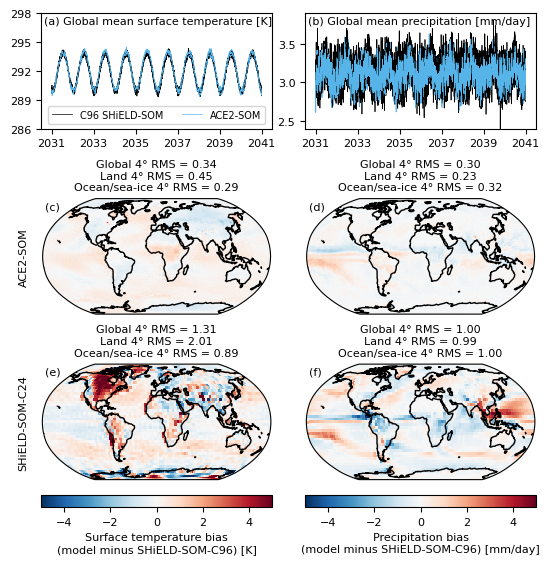

In [ ]:
fig, (ax5, ax6, ax3, ax4, ax1, ax2), (cax1, cax2) = plotting.width_constrained_plot(
    3,
    2,
    5.5,
    0.5,
    cbar_pad=0.15,
    horizontal_pads=[0.33],
    vertical_pads=[0.5, 0.7],
    left_pad=0.4,
    bottom_pad=0.6,
    top_pad=0.1,
    right_pad=0.15,
    axes_kwargs={"projection": ccrs.Robinson()},
)

# Remove projection from axes[0] and axes[1].
position = ax1.get_position(original=True)
ax1.set_visible(False)
ax1 = fig.add_axes(position)

position = ax2.get_position(original=True)
ax2.set_visible(False)
ax2 = fig.add_axes(position)

for initial_condition in time_series.initial_condition:
    if initial_condition.item() == "ic1":
        label_shield = "C96 SHiELD-SOM"
        label_ace = "ACE2-SOM"
    else:
        label_shield = None
        label_ace = None
    time_series.sel(
        model="SHiELD-SOM-C96", initial_condition=initial_condition
    ).surface_temperature.plot(ax=ax1, color="k", lw=0.5, label=label_shield)
    time_series.sel(
        model="ACE2-SOM-multi-climate-RS3", initial_condition=initial_condition
    ).surface_temperature.plot(ax=ax1, color="C0", lw=0.5, label=label_ace)

for initial_condition in time_series.initial_condition:
    if initial_condition.item() == "ic1":
        label_shield = "C96 SHiELD-SOM"
        label_ace = "ACE2-SOM"
    else:
        label_shield = None
        label_ace = None
    time_series.sel(
        model="SHiELD-SOM-C96", initial_condition=initial_condition
    ).PRATEsfc.plot(ax=ax2, color="k", lw=0.5, label=label_shield)
    time_series.sel(
        model="ACE2-SOM-multi-climate-RS3", initial_condition=initial_condition
    ).PRATEsfc.plot(ax=ax2, color="C0", lw=0.5, label=label_ace)

ax1.set_ylim(286, 298)
ax2.set_ylim(2.4, 3.9)

ax1.set_yticks([286, 289, 292, 295, 298])

ax1.set_title("")
ax2.set_title("")

for ax in (ax1, ax2):
    ax.set_xticks(pd.date_range("2031", "2041", freq="2YS"))
    ax.set_xlabel("")
    ax.set_ylabel("")

ax1.legend(ncol=2, fontsize=7, loc="lower center")

vmin, vmax = -7.5, 7.5
vmin, vmax = -5, 5
cmap = "RdBu_r"
p1 = one_degree_pattern_error.sel(
    model="ACE2-SOM-multi-climate-RS3"
).surface_temperature.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    add_colorbar=False,
)
p1 = four_degree_pattern_error.sel(
    model="SHiELD-SOM-C24-tuned-cdmbgwd"
).surface_temperature.plot(
    ax=ax5,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    add_colorbar=False,
)

ax3.set_title(
    get_title(
        rmse, "surface_temperature", "3xCO2", "ACE2-SOM-multi-climate-RS3", "4° RMS"
    )
)
ax5.set_title(
    get_title(
        rmse, "surface_temperature", "3xCO2", "SHiELD-SOM-C24-tuned-cdmbgwd", "4° RMS"
    )
)

fig.colorbar(
    p1,
    cax=cax1,
    orientation="horizontal",
    label="Surface temperature bias\n(model minus SHiELD-SOM-C96) [K]",
)

# vmin, vmax = -7.5, 7.5
vmin, vmax = -5, 5
cmap = "RdBu_r"
p2 = one_degree_pattern_error.sel(model="ACE2-SOM-multi-climate-RS3").PRATEsfc.plot(
    ax=ax4,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    add_colorbar=False,
)
p2 = four_degree_pattern_error.sel(model="SHiELD-SOM-C24-tuned-cdmbgwd").PRATEsfc.plot(
    ax=ax6,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    add_colorbar=False,
)

ax4.set_title(
    get_title(rmse, "PRATEsfc", "3xCO2", "ACE2-SOM-multi-climate-RS3", "4° RMS")
)
ax6.set_title(
    get_title(rmse, "PRATEsfc", "3xCO2", "SHiELD-SOM-C24-tuned-cdmbgwd", "4° RMS")
)

fig.colorbar(
    p2,
    cax=cax2,
    orientation="horizontal",
    label="Precipitation bias\n(model minus SHiELD-SOM-C96) [mm/day]",
)

for ax in (ax3, ax4, ax5, ax6):
    ax.coastlines()

ax1.annotate(
    "(a) Global mean surface temperature [K]",
    xy=(0, 1),
    xytext=(2, -2),
    va="top",
    xycoords="axes fraction",
    textcoords="offset points",
)
ax2.annotate(
    "(b) Global mean precipitation [mm/day]",
    xy=(0, 1),
    xytext=(2, -2),
    va="top",
    xycoords="axes fraction",
    textcoords="offset points",
)

for ax, label in zip((ax3, ax4, ax5, ax6), ("c", "d", "e", "f")):
    ax.annotate(
        f"({label})",
        xy=(0, 1),
        xytext=(2, -2),
        va="top",
        xycoords="axes fraction",
        textcoords="offset points",
    )


ax3.annotate(
    "ACE2-SOM",
    xy=(0, 0.5),
    xytext=(-10, 0),
    xycoords="axes fraction",
    textcoords="offset points",
    ha="right",
    va="center",
    rotation=90,
)
ax5.annotate(
    "C24 SHiELD-SOM",
    xy=(0, 0.5),
    xytext=(-10, 0),
    xycoords="axes fraction",
    textcoords="offset points",
    ha="right",
    va="center",
    rotation=90,
)

fig.savefig("figures/figure-01.pdf")
fig.savefig("figures/figure-01.png", dpi=200)
